For personal tests outside of demo to avoid repo push conflicts

In [1]:
import sys
sys.path.append('../code/')

from nsmodel import *
from analysis import *

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def SpaceTimePlot(cells, system_density, timesteps, bottleneck=False,
                        random_state=None, save_file_name="", 
                        v_max=5, p=0.5, t0=None, initial_state=None,
                        bn_start=None, bn_end=None, v_max_bn=1, inflow=0.5):
    """
    Function to streamline creation of the time evolution plots of the traffic lane 
    cells from the Nagel–Schreckenberg models. Displays the plot in jupyter notebook. 
    Optionally saves the .jpg file.

    Parameters:
        cells (int): The number of cells in the traffic lane, which can be occupied 
            by 0 or 1 car.
        system_density (float): The total density of cars in the system. The number 
            of cars passed to the traffic model will equal int(system_density * cells).
            Float must be between 0 and 1.
        timesteps (int): The number of timesteps to simulate for data collection.
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        
        save_file_name (str): Name of the .jpg file, if saving the plot. If unnamed,
            the plot won't be saved.


        v_max (int): Speed limit of the traffic system.
        p (float): Probability factor for random decceleration events. Float must 
            be between 0 and 1.
        t0 (int): Initial number of timesteps to run the system through to reach a 
            state of equilibrium before data collection starts. If None, 10 * cells 
            is used.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.

        bn_start (int or None): The starting cell index of the bottleneck region. If None, no bottleneck
            region is used.
        bn_end (int or None): The ending cell index of the bottleneck. If None, there is no bottleneck.
        v_max_bn (int): The maximum veolcity inside the bottleneck region.
        inflow (float): The probability that a new car enters the traffic lane at index 0 when that cell
            is empty.
    """


    cars = int(system_density * cells)

    if bottleneck:
        model = TrafficBottleneck(cars, cells=cells, v_max=v_max, p=p, t0=t0, random_state=random_state, 
                                  initial_state=initial_state, bn_start=bn_start, bn_end=bn_end, 
                                  v_max_bn=v_max_bn, inflow=inflow)
    else:
        model = TrafficModelCircular(cars, cells, v_max, p, t0, random_state, initial_state)
   
    model.simulate(timesteps)
    data = np.asarray(model.history)

    fig, ax = plt.subplots(figsize=(0.12*cells, timesteps//10), dpi=300)
    im = ax.imshow(data, cmap='Greys')

    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    ax.set_ylabel("Timestep", fontsize=12)
    ax.set_xlabel("Cell Index", fontsize=12)
    ax.set_title("Time Evolution of Single, Circular Traffic Lane", fontsize=14)
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label(f"Car Velocity (cells/timestep)\n(-1 indicates no cars present)", fontsize=10, labelpad=1)

    if save_file_name:
        file = save_file_name + ".jpg"
        # put the file in specific folder ?
        plt.savefig(file, format='jpg', bbox_inches='tight')
    
    plt.show()

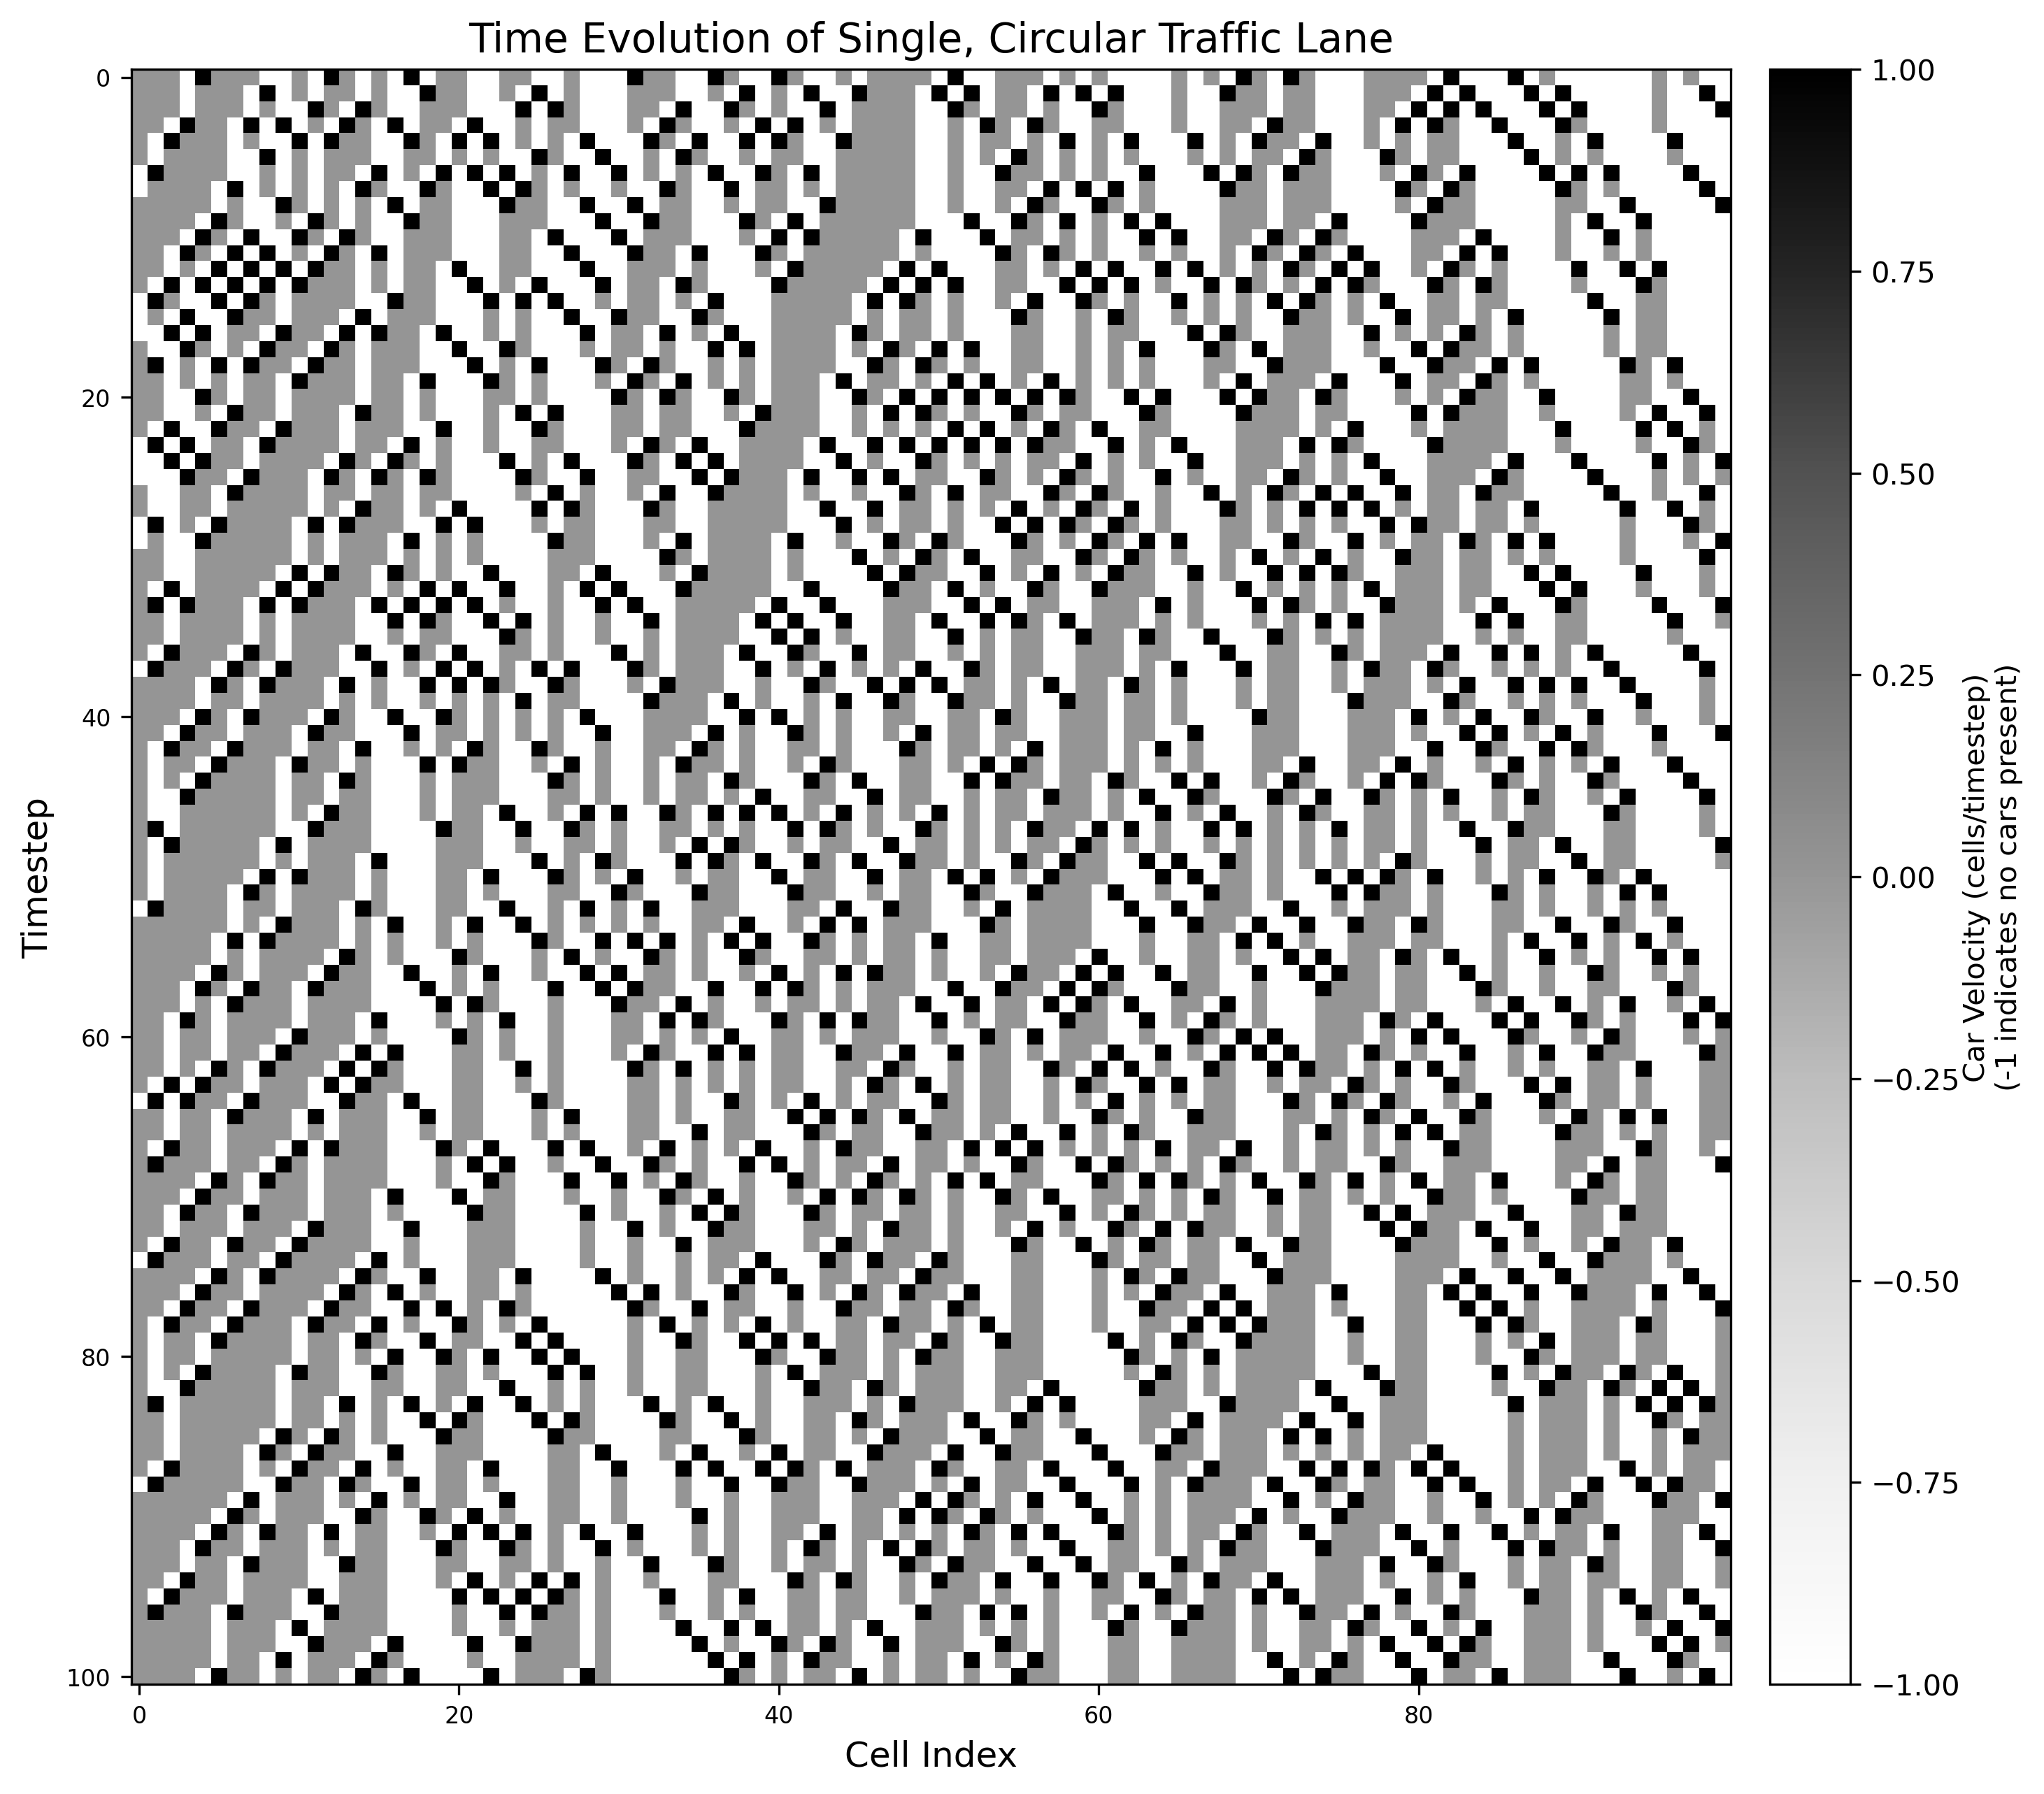

In [2]:
x = TrafficBottleneck(50, v_max=1)
x.simulate(100)

data = x.history

fig, ax = plt.subplots(figsize=(12, 10), dpi=300)
im = ax.imshow(data, cmap='Greys')

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

ax.set_ylabel("Timestep", fontsize=12)
ax.set_xlabel("Cell Index", fontsize=12)
ax.set_title("Time Evolution of Single, Circular Traffic Lane", fontsize=14)
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(f"Car Velocity (cells/timestep)\n(-1 indicates no cars present)", fontsize=10, labelpad=1)

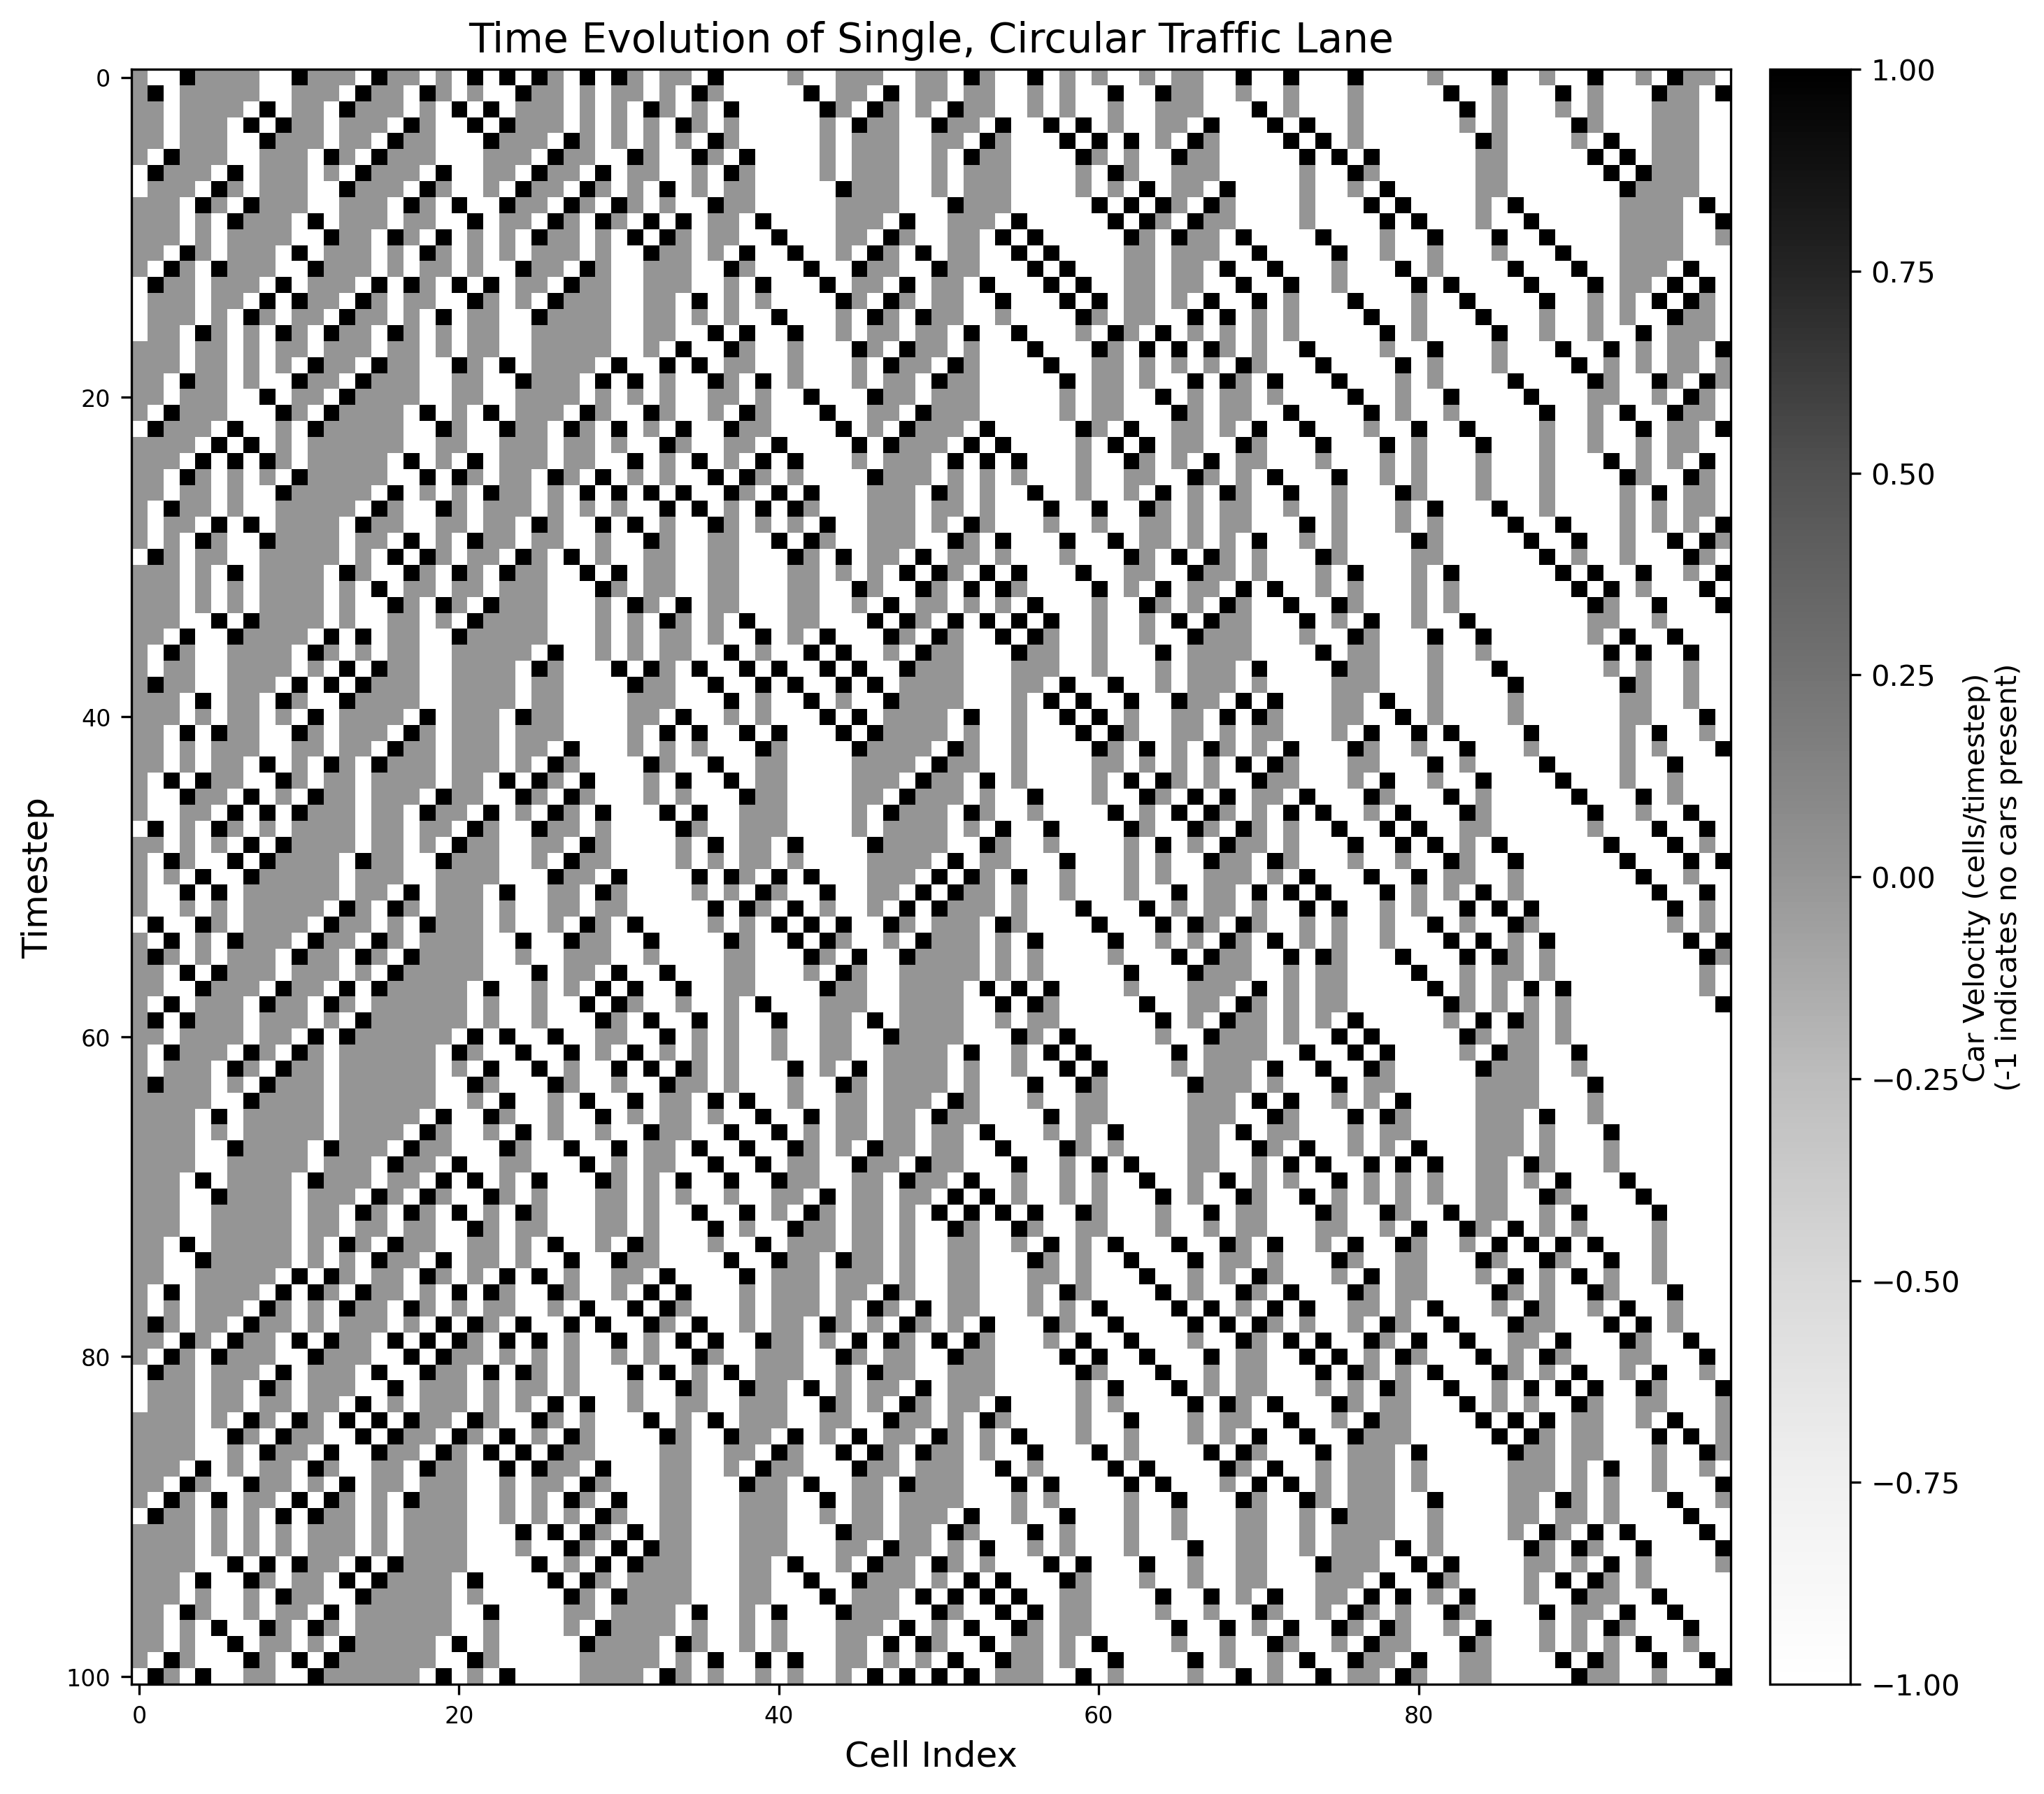

In [3]:
SpaceTimePlot(100,0.2,100, bottleneck=True, v_max=1)

In [ ]:
# ρ_T: density of a given index over specific time period
#       = 1/T Σn_i    ; where n=1 if occupied, 0 if not
#       for large T, ρ_T approaches system ρ
#
# q_t: flow past given index over specifc time period
#       = 1/T Σn_i    ; where n=1 if a car moves between index i and i+1
#
# Data collection:
#   - (could take from a couple indices from same simulation)
#   - take some with T = 10^6
#   - some with T = 10^2
#   - cells = 10^4

# Function for deriving traffic flow vs density:

In [2]:
def DensityFlowResults(cells, system_density, timesteps, random_state=None, 
                       sample_spacing=100, first_sample=50,
                       v_max=5, p=0.5, t0=None, initial_state=None):
    """
    Function to streamline the collection of traffic flow vs. density data from the 
    Nagel–Schreckenberg models. 
    Output: a tuple of two 1d numpy arrays; ([density], [flow])

    Parameters:
        cells (int): The number of cells in the traffic lane, which can be occupied 
            by 0 or 1 car.
        system_density (float): The total density of cars in the system. The number 
            of cars passed to the traffic model will equal int(system_density * cells).
            Float must be between 0 and 1.
        timesteps (int): The number of timesteps to simulate for data collection.
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.

        sample_spacing (int): Steps to take between the sampled cell indices used for 
            data collection. Defaults to 100.
        first_sample (int): First index to start the sample cell selection with. 
            Defaults to 50.

        v_max (int): Speed limit of the traffic system.
        p (float): Probability factor for random decceleration events. Float must 
            be between 0 and 1.
        t0 (int): Initial number of timesteps to run the system through to reach a 
            state of equilibrium before data collection starts. If None, 10 * cells 
            is used.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
    """

    cars = int(system_density * cells)
    model = TrafficModelCircular(cars, cells, v_max, p, t0, random_state, initial_state)
    model.simulate(timesteps)
    history = np.asarray(model.history)

    sample_indices = np.arange(first_sample, cells, sample_spacing)

    transpose = history.T
    occupy = np.where(transpose[sample_indices]>-1, 1, 0)
    occupy_sum = np.sum(occupy, axis=1)
    density = occupy_sum / timesteps

    flow_conditions = [transpose[sample_indices-i]>i for i in range(v_max)]
    flow = np.where(np.logical_or.reduce(flow_conditions), 1, 0)
    #
    # print(f"flow conditions: {flow_conditions}\nflow locations: {flow}\n")
    #
    flow = np.sum(flow, axis=1, dtype=float)
    flow /= timesteps

    return (density, flow)


In [3]:
density_s1, flow_s1 = DensityFlowResults(cells=10**4, system_density=0.2, 
                                   timesteps=10**2, random_state=123)
[density_s1, flow_s1]

[array([0.07, 0.59, 0.23, 0.26, 0.1 , 0.09, 0.1 , 0.54, 0.23, 0.28, 0.29,
        0.07, 0.11, 0.07, 0.08, 0.08, 0.03, 0.07, 0.25, 0.32, 0.13, 0.39,
        0.08, 0.05, 0.06, 0.07, 0.26, 0.38, 0.2 , 0.09, 0.08, 0.07, 0.06,
        0.07, 0.08, 0.08, 0.29, 0.4 , 0.55, 0.32, 0.37, 0.08, 0.05, 0.37,
        0.35, 0.39, 0.13, 0.06, 0.31, 0.09, 0.07, 0.43, 0.06, 0.06, 0.4 ,
        0.3 , 0.23, 0.54, 0.34, 0.52, 0.29, 0.22, 0.08, 0.09, 0.06, 0.05,
        0.5 , 0.36, 0.05, 0.64, 0.26, 0.44, 0.1 , 0.14, 0.05, 0.08, 0.05,
        0.05, 0.52, 0.05, 0.08, 0.05, 0.32, 0.17, 0.09, 0.37, 0.33, 0.08,
        0.23, 0.47, 0.5 , 0.36, 0.13, 0.11, 0.51, 0.17, 0.08, 0.09, 0.48,
        0.55]),
 array([0.3 , 0.14, 0.25, 0.25, 0.29, 0.41, 0.35, 0.19, 0.26, 0.32, 0.21,
        0.32, 0.33, 0.31, 0.29, 0.31, 0.29, 0.29, 0.38, 0.23, 0.24, 0.22,
        0.22, 0.26, 0.29, 0.32, 0.26, 0.29, 0.32, 0.31, 0.32, 0.28, 0.3 ,
        0.31, 0.29, 0.32, 0.21, 0.26, 0.2 , 0.21, 0.27, 0.34, 0.28, 0.23,
        0.34, 0.25, 0.

In [5]:
density_s2, flow_s2 = DensityFlowResults(cells=10**4, system_density=0.2, 
                                   timesteps=10**2, random_state=5603)
density_s3, flow_s3 = DensityFlowResults(cells=10**4, system_density=0.2, 
                                   timesteps=10**2, random_state=962)

In [10]:
density_s4, flow_s4 = DensityFlowResults(cells=10**4, system_density=0.1, 
                                   timesteps=10**2, random_state=None)

In [11]:
density_s5, flow_s5 = DensityFlowResults(cells=10**4, system_density=0.03, 
                                   timesteps=10**2, random_state=None)

In [17]:
density_s6, flow_s6 = DensityFlowResults(cells=10**4, system_density=0.05, 
                                   timesteps=10**2, random_state=None)

In [ ]:
# density_b1, flow_b1 = DensityFlowResults(cells=10**4, system_density=0.2, 
#                                    timesteps=10**6, random_state=None)

: 

Text(0.5, 0, 'Density (cell occupancy / timestep)')

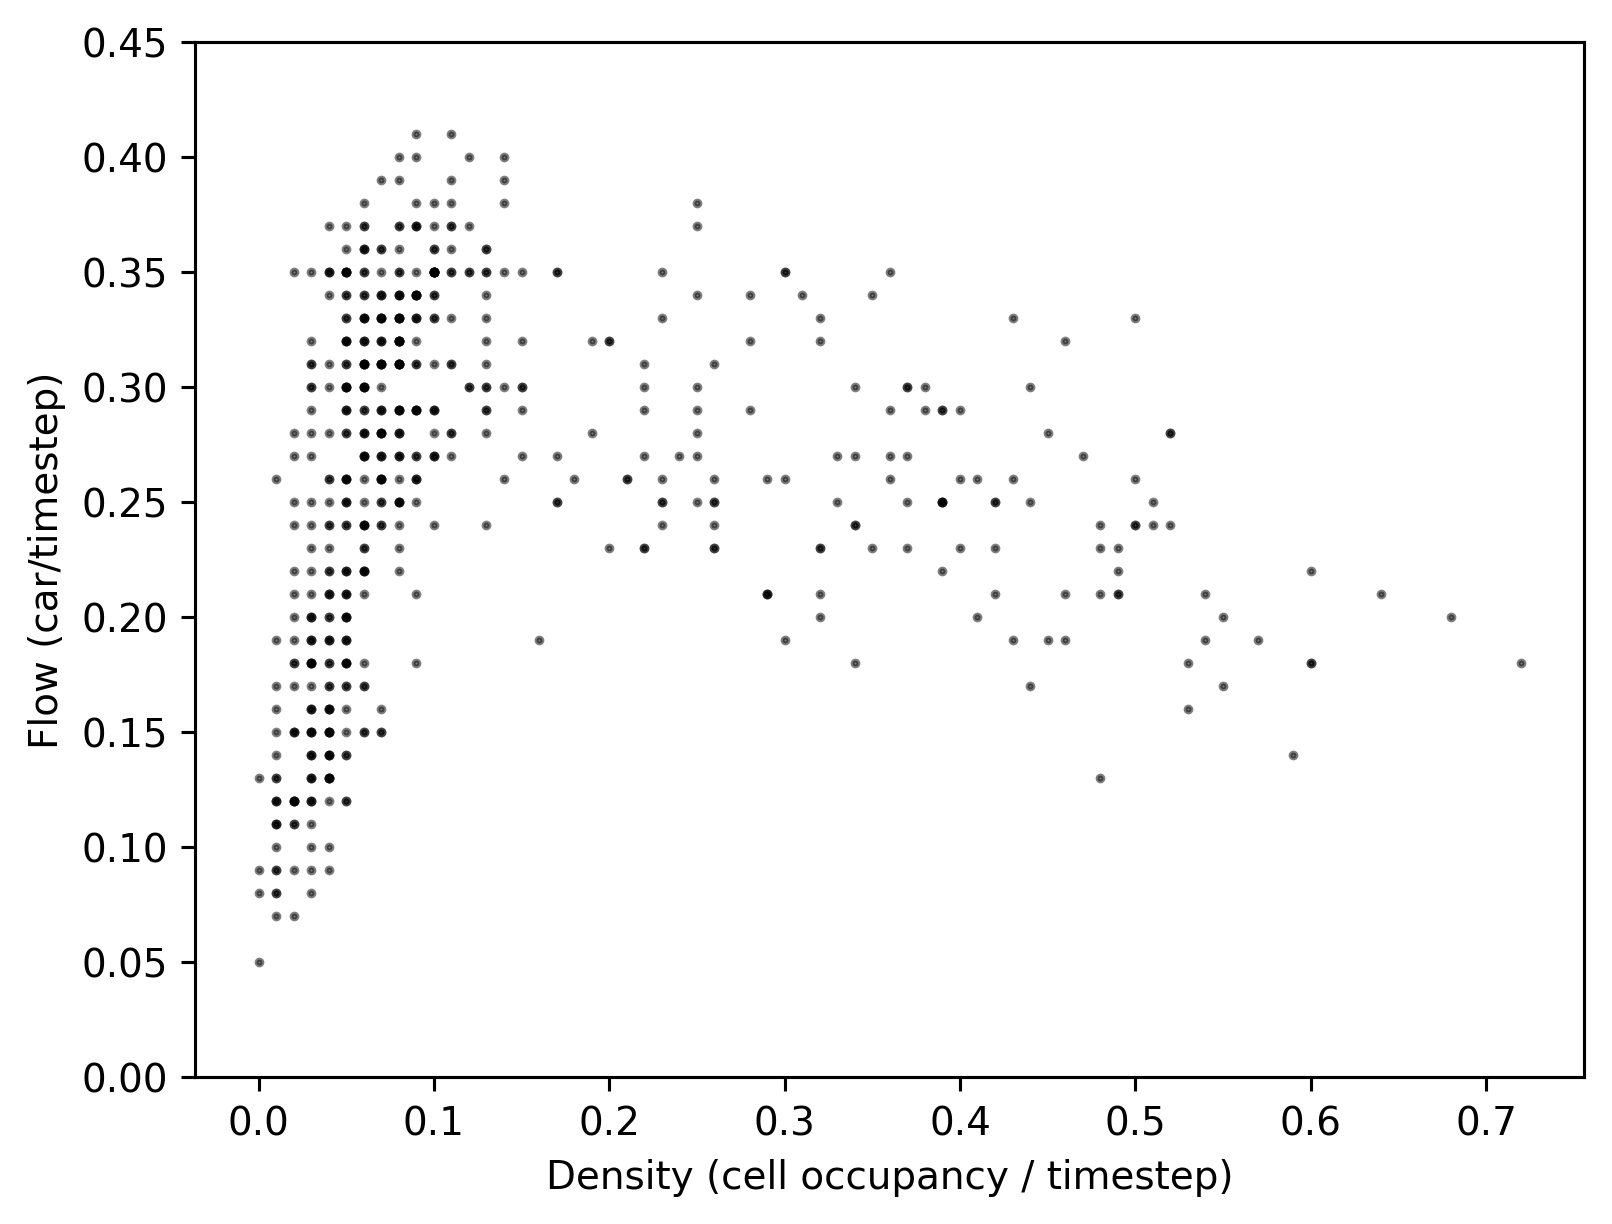

In [20]:
plt.figure(dpi=280)
plt.plot(density_s1, flow_s1, ".k", ms=3, alpha=0.5)
plt.plot(density_s2, flow_s2, ".k", ms=3, alpha=0.5)
plt.plot(density_s3, flow_s3, ".k", ms=3, alpha=0.5)
plt.plot(density_s4, flow_s4, ".k", ms=3, alpha=0.5)
plt.plot(density_s5, flow_s5, ".k", ms=3, alpha=0.5)
plt.plot(density_s6, flow_s6, ".k", ms=3, alpha=0.5)

# plt.plot(density_b1, flow_b1, ".r", ms=3)

plt.ylim(0,0.45)
plt.ylabel("Flow (car/timestep)")
plt.xlabel("Density (cell occupancy / timestep)")
# plt.title()

In [ ]:
# dummy array testing

x = np.full((3,4), 1)
x[0][2], x[1][1], x[2][3], x[2][1] = 3, 5, 2, 4
print(x, "\n")
y = np.where(x[[0,1,2]]>1, 1, 0)
print(y, "\n")
z = np.sum(y, axis=1)
print(z)

[[1 1 3 1]
 [1 5 1 1]
 [1 4 1 2]] 

[[0 0 1 0]
 [0 1 0 0]
 [0 1 0 1]] 

[1 1 2]
